In [397]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [160]:
df_original = pd.read_csv('C:\\Users\\Liu Shi Peng\\Downloads\\heart.csv')
df_original.shape

(918, 12)

In [161]:
df = df_original.copy()

### 1. exploratory data analysis

In [163]:
print(df.dtypes)
df.describe()

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [164]:
## missing data
missing_data_count = df.isnull().sum()
print(missing_data_count)

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [165]:
## zero value data
zero_data = df == 0
zero_data.sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       172
FastingBS         704
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak           368
ST_Slope            0
HeartDisease      410
dtype: int64

In [166]:
## remove missing value data
df_nomissing = df[df['RestingBP']!=0]
df_nomissing.shape

(917, 12)

In [167]:
df_nomissing.loc[df_nomissing['Cholesterol']==0, 'Cholesterol'] = df_nomissing['Cholesterol'].median()
# df_nomissing['Cholesterol'] = df_nomissing['Cholesterol'].replace(0, df_nomissing['Cholesterol'].median())
df_nomissing.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,53.509269,132.540894,240.600872,0.233370,136.789531,0.886696,0.552890
std,9.437636,17.999749,54.009298,0.423206,25.467129,1.066960,0.497466
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


### 1.1 - feature correlation

#### 1.1 - a. correlation among numerical features

                   Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak  \
Age           1.000000   0.263084     0.031037   0.198170 -0.382280  0.258563   
RestingBP     0.263084   1.000000     0.090791   0.067823 -0.109693  0.174252   
Cholesterol   0.031037   0.090791     1.000000  -0.008243  0.026997  0.056948   
FastingBS     0.198170   0.067823    -0.008243   1.000000 -0.131067  0.053062   
MaxHR        -0.382280  -0.109693     0.026997  -0.131067  1.000000 -0.161213   
Oldpeak       0.258563   0.174252     0.056948   0.053062 -0.161213  1.000000   
HeartDisease  0.282012   0.117990     0.043329   0.267994 -0.401410  0.403638   

              HeartDisease  
Age               0.282012  
RestingBP         0.117990  
Cholesterol       0.043329  
FastingBS         0.267994  
MaxHR            -0.401410  
Oldpeak           0.403638  
HeartDisease      1.000000  


<Axes: >

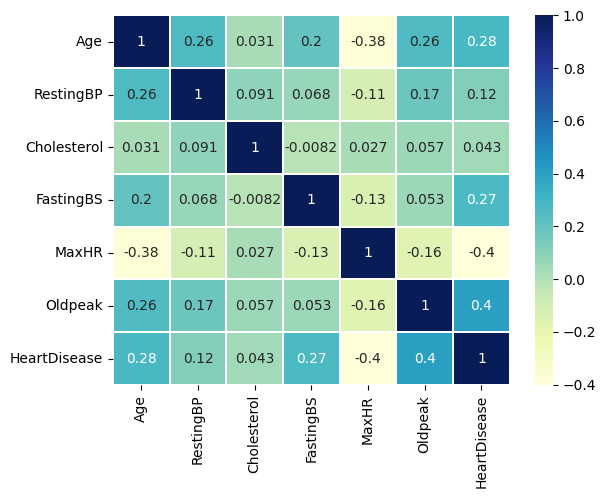

In [170]:
correlation = df_nomissing.corr(numeric_only=True)
print(correlation)
sns.heatmap(correlation,cmap="YlGnBu", annot=True, linewidths=0.1)

#### 1.1 - b. correlation among categorical features

In [172]:
import scipy.stats as stats
def chi_square_test(df):
    cols = df.columns
    results = {}
    print(len(cols))
    p_values = np.zeros((len(cols), len(cols)))
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            # Create a contingency table
            contingency_table = pd.crosstab(df[cols[i]], df[cols[j]])
            # Perform Chi-Square test
            chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
            p_values[i,j] = p
            p_values[j,i] = p

            # Save results
            results[f"{cols[i]} vs {cols[j]}"] = {"p_value": p}
    return p_values.astype('f')

In [173]:
cat_columns = ['Sex', 'ChestPainType', 'RestingECG','ExerciseAngina','ST_Slope', 'HeartDisease']

In [174]:
chi_test_df = df_nomissing[cat_columns]

6


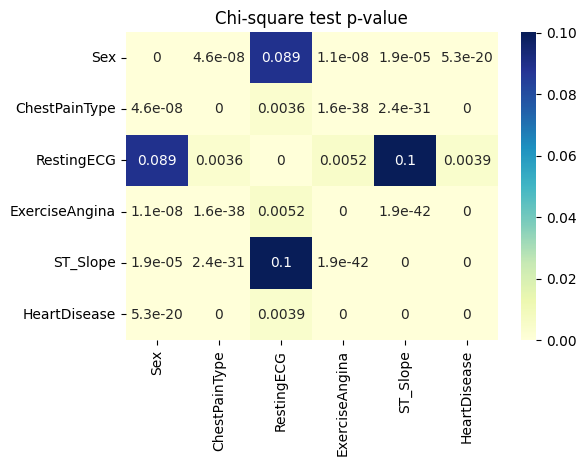

In [175]:
plt.figure(figsize=(6, 4))
sns.heatmap(chi_square_test(chi_test_df), cmap="YlGnBu", annot=True, xticklabels = cat_columns, yticklabels = cat_columns )
plt.title('Chi-square test p-value')
plt.show()

### 1.2 - distribution plot

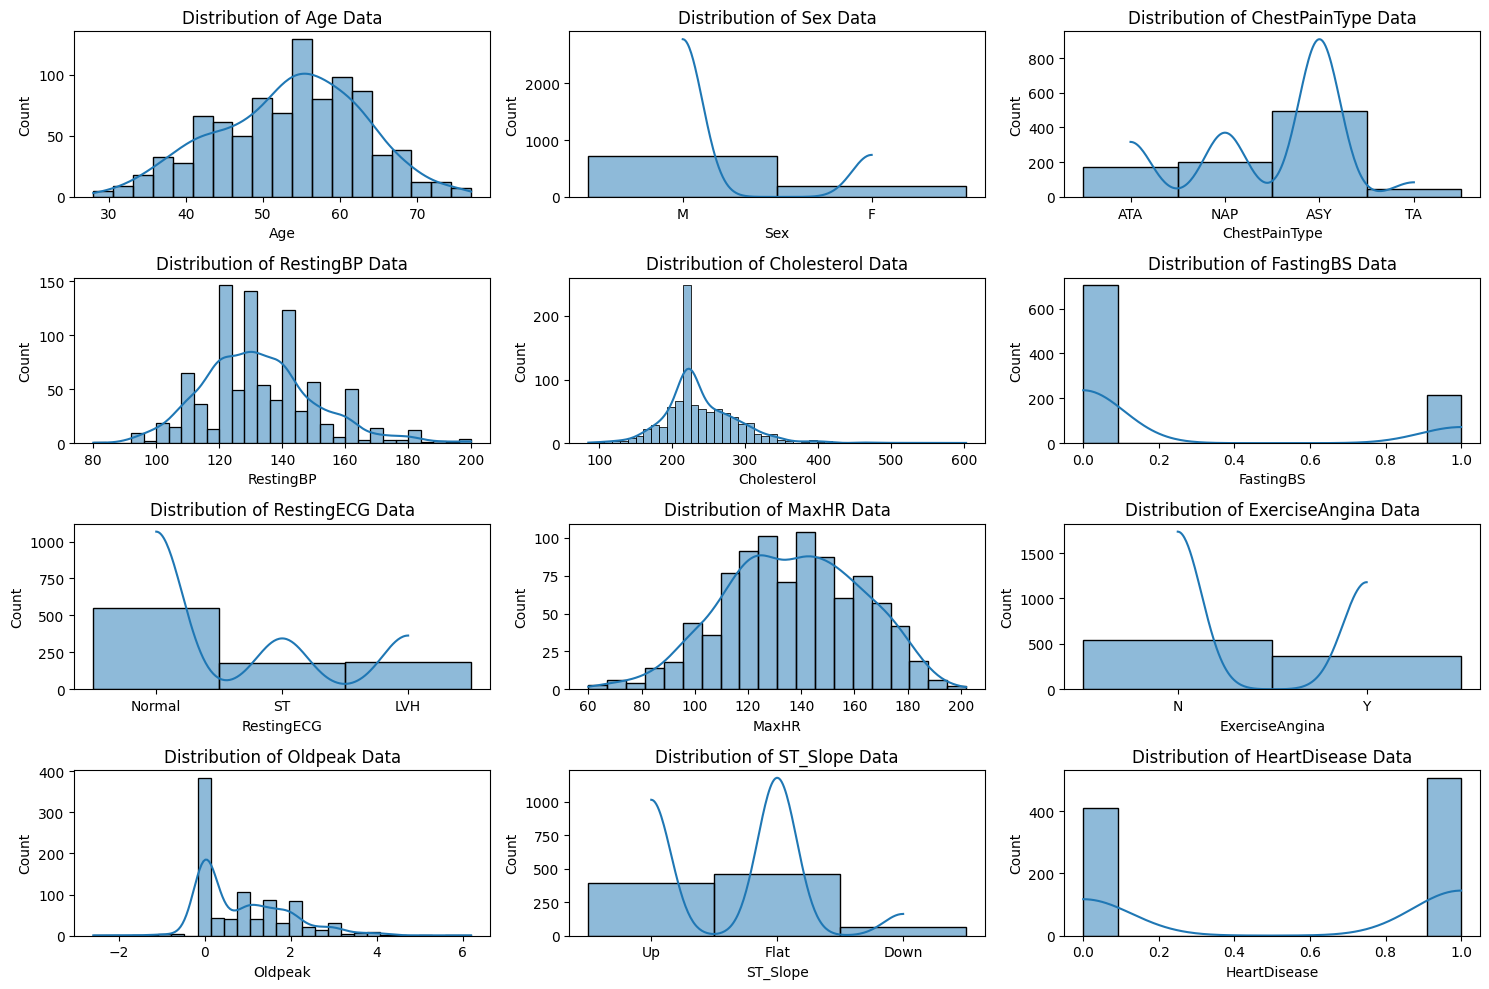

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
for i,col in enumerate(df_nomissing.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    # plt.hist(df[col], bins = 20, log = True)
    sns.histplot(df_nomissing[col],kde=True)
    plt.tight_layout()
    plt.plot()

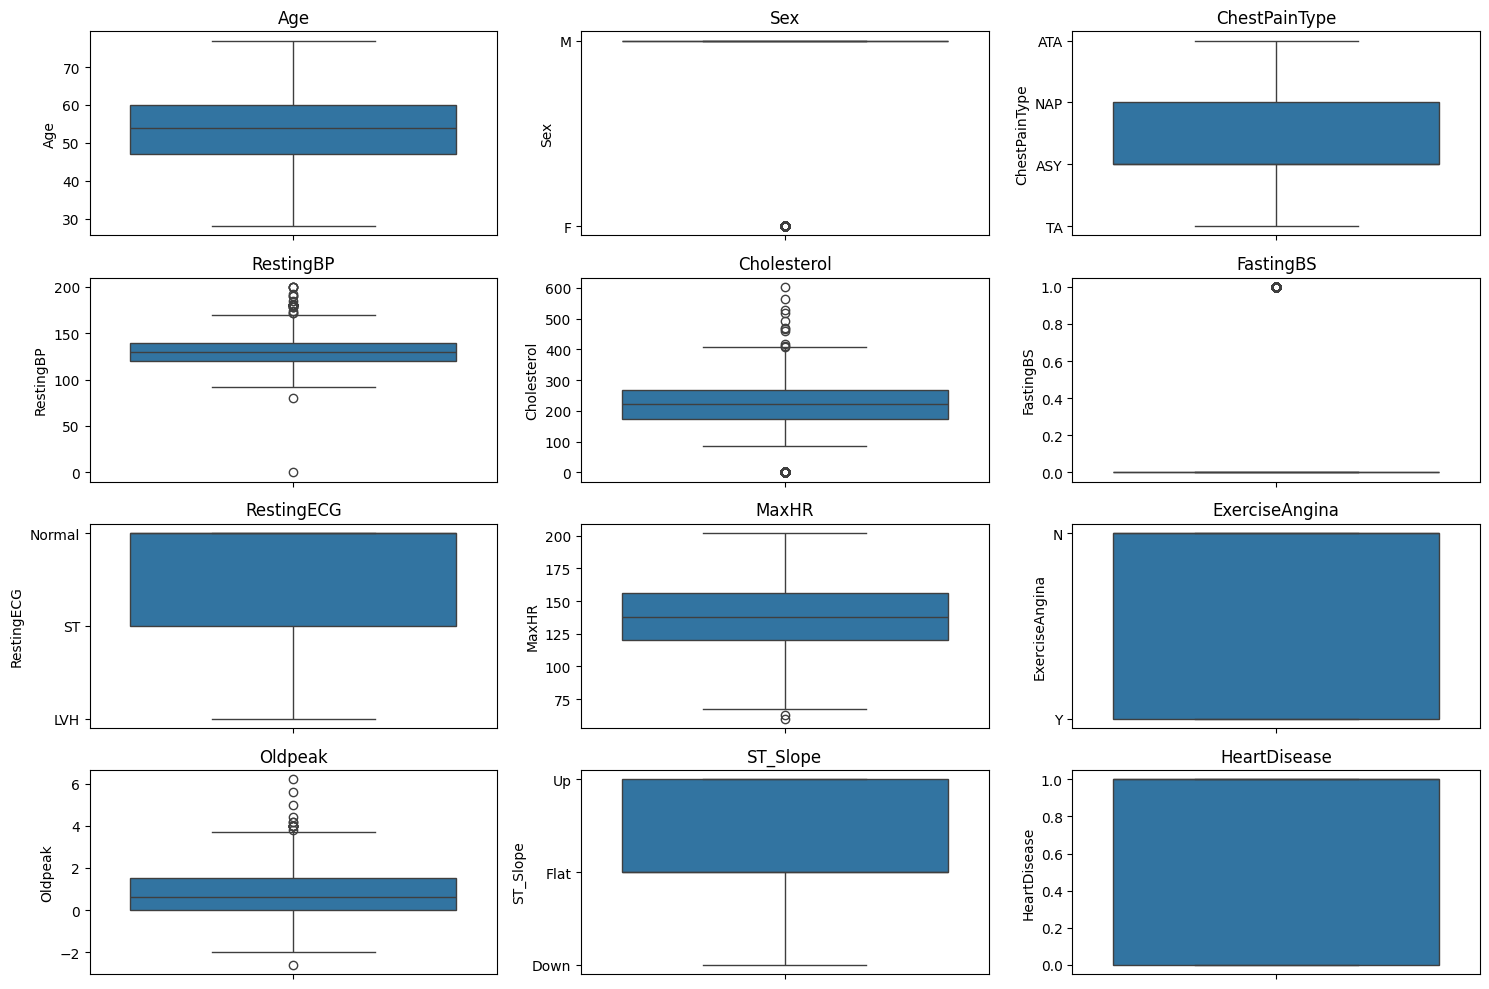

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

# Loop through each column to generate a boxplot
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns, 1):
    plt.subplot(4,3,i)
    plt.title(f'{column}')
    sns.boxplot(df[column])
plt.tight_layout()
plt.show()

### 1.3 - outlier detection

In [180]:
df_no_outlier = df_nomissing.copy()

In [181]:
cat_columns = ['Sex', 'ChestPainType', 'RestingECG','ExerciseAngina','ST_Slope']
df_one_hot = pd.get_dummies(df_no_outlier, columns = cat_columns, dtype=float)
df_one_hot.shape

(917, 21)

#### 1.3.1 - gaussian error detection

In [183]:
numeric_col = ['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak','HeartDisease']

In [184]:
from scipy import stats
z_scores = np.abs(stats.zscore(df_one_hot[numeric_col]))

threshold = 3
# pd.DataFrame(np.where(z_scores > threshold))
df_error = z_scores > threshold
# df1_error.sum()
df_error['sum_error'] = df_error.sum(axis = 1)
error_index = df_error[df_error['sum_error']>=1].index
error_index

Index([ 28,  30,  69,  76, 103, 109, 149, 166, 182, 241, 250, 324, 365, 390,
       399, 496, 592, 616, 624, 667, 702, 732, 759, 771, 791, 796, 850, 900],
      dtype='int64')

#### 1.3.2 - isolation forest detection

In [338]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
outliers = iso_forest.fit_predict(df_one_hot)
error_index_if  = np.where(outliers==-1)[0]
# -1 indicates an outlier
# df_no_outlier['outlier'] = outliers
# error_index_if = df_no_outlier[df_no_outlier['outlier'] == -1].index
error_index_if 

array([517, 540, 546, 678, 701, 731, 732, 749, 849, 857], dtype=int64)

In [340]:
df_no_outlier = df_one_hot[~df_one_hot.index.isin(error_index )]
df_no_outlier.shape

(889, 21)

## 2. Modelling

In [343]:
dfm = df_no_outlier.copy()

In [345]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [347]:
features = [x for x in dfm.columns if x not in ('HeartDisease')]
len(features)

20

In [349]:
X = dfm[features]
y = dfm['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 41)
print('train shape', X_train.shape)
print('test shape', X_test.shape)

train shape (595, 20)
test shape (294, 20)


### Decision Tree

In [69]:
# from sklearn.metrics import accuracy_score
# for min_leaf in range(1,30,2):
#     for min_split in range(2, 30, 2): 
#         model = DecisionTreeClassifier(min_samples_split = min_split, min_samples_leaf = min_leaf).fit(X_train, y_train)
#         pred_train = model.predict(X_train)
#         pred_test = model.predict(X_test)
#         accuracy_train = accuracy_score(pred_train, y_train)
#         accuracy_test = accuracy_score(pred_test, y_test)
#         print('min_leaf:', min_leaf, 'min_split:', min_split, 'accuracy:',(f'{accuracy_train:.2f}', f'{accuracy_test:.2f}'))

In [71]:
# for min_leaf in range(1,30,2):
#     for min_split in range(2, 30, 2): 
#         model = RandomForestClassifier(min_samples_split = min_split, min_samples_leaf = min_leaf).fit(X_train, y_train)
#         pred_train_forest = model.predict(X_train)
#         pred_test_forest = model.predict(X_test)
#         accuracy_train = accuracy_score(pred_train_forest, y_train)
#         accuracy_test = accuracy_score(pred_test_forest, y_test)
#         print('min_leaf:', min_leaf, 'min_split:', min_split, 'accuracy:',(f'{accuracy_train:.2f}', f'{accuracy_test:.2f}'))

In [351]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Initialize the Decision Tree model
dt = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'splitter': ['best', 'random'],    # Strategy used to choose the split at each node
    'max_depth': [None, 10, 20, 30],   # Maximum depth of the tree
    'min_samples_split': np.arange(2,30, 2),   # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1,10),     # Minimum number of samples required to be at a leaf node
    #'max_features': [None, 'auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
}

grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)
best_model_dt = grid_search_dt.best_estimator_
# Print the best parameters and the best score
print(f"Best parameters found: {grid_search_dt.best_params_}")

pred_train = best_model_dt.predict(X_train)
pred_test = best_model_dt.predict(X_test)
accuracy_train = accuracy_score(pred_train, y_train)
accuracy_test = accuracy_score(pred_test, y_test)
print('Accuracy', (f'{accuracy_train:.4f}', f'{accuracy_test:.4f}'))

Best parameters found: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 3, 'min_samples_split': 24, 'splitter': 'random'}
Accuracy ('0.8857', '0.8299')


In [336]:
feature_importance = best_model_dt.feature_importances_
feature_importance_df = pd.DataFrame({'fatures': X.columns, 'importance':best_model_dt.feature_importances_})
feature_importance_df.sort_values(by = 'importance', ascending = False)

,fatures,importance
19,ST_Slope_Up,0.543490
8,ChestPainType_ASY,0.175398
3,FastingBS,0.079504
7,Sex_M,0.055873
15,ExerciseAngina_N,0.028390
14,RestingECG_ST,0.026618
12,RestingECG_LVH,0.015389
9,ChestPainType_ATA,0.013459
5,Oldpeak,0.012795
18,ST_Slope_Flat,0.010252


### Random Forecast

In [98]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'max_depth': [10, 20, 30],   # Maximum depth of the tree
    'min_samples_split': np.arange(2,20, 3),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1, 10, 2),  # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
    #'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs = -1, scoring='accuracy')

# Fit the model
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters found: {grid_search_rf.best_params_}")

# Evaluate the best model on the test set
best_model_rf = grid_search_rf.best_estimator_
pred_train = best_model_rf.predict(X_train)
pred_test = best_model_rf.predict(X_test)
accuracy_train = accuracy_score(pred_train, y_train)
accuracy_test = accuracy_score(pred_test, y_test)
print('Accuracy', (f'{accuracy_train:.4f}', f'{accuracy_test:.4f}'))

Best parameters found: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 11, 'n_estimators': 100}
Accuracy ('0.9153', '0.8923')


### XGB model

In [369]:
from xgboost import XGBClassifier
import xgboost as xgb

In [383]:
# n = int(len(X_train)*0.8)
# X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

xgb_model = XGBClassifier(n_estimators = 200, learning_rate = 0.1, max_depth = 2)
xgb_model.fit(X_train,y_train) #, eval_set = [(X_train_eval,y_train_eval)]

pred_train = xgb_model.predict(X_train)
pred_test = xgb_model.predict(X_test)

accuracy_train = accuracy_score(pred_train, y_train)
accuracy_test = accuracy_score(pred_test, y_test)
print('Accuracy', (f'{accuracy_train:.4f}', f'{accuracy_test:.4f}'))

Accuracy ('0.9277', '0.8537')


In [156]:
params = {
    'learning_rate':np.arange(0.01, 0.2, 0.02),
    'n_estimators':np.arange(100,500,100),
    'max_depth': [3,5], 
    'gamma': [0, 0.1, 0.2, 0.3],
}

param_grid = {
    'max_depth': [3, 5,7,9],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 0.2]
}

xgb_model = XGBClassifier()

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)
# Print the best parameters and the best score
print(f"Best parameters found: {grid_search_xgb.best_params_}")

# Evaluate the best model on the test set
best_model_xgb = grid_search_xgb.best_estimator_
pred_train = best_model_xgb.predict(X_train)
pred_test = best_model_xgb.predict(X_test)
accuracy_train = accuracy_score(pred_train, y_train)
accuracy_test = accuracy_score(pred_test, y_test)
print('Accuracy', (f'{accuracy_train:.4f}', f'{accuracy_test:.4f}'))

Best parameters found: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0.2, 'reg_lambda': 0.1, 'subsample': 0.9}
Accuracy ('0.9529', '0.8673')


### Logistic Regression

In [427]:
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(random_state=0).fit(X_train_scaled , y_train)

pred_train = model.predict(X_train_scaled)
pred_test = model.predict(X_test_scaled)
accuracy_train = accuracy_score(pred_train, y_train)
accuracy_test = accuracy_score(pred_test, y_test)
print(f'{accuracy_train:.4f}', 'accuracy_test', f'{accuracy_test:.4f}')

0.8689 accuracy_test 0.8605


### Naive Bayers Classifier

In [425]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = GaussianNB()
# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8435


### K-NN classifer

In [359]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
k_values = range(1, 31)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the value of k that gives the highest cross-validation score
best_k = k_values[np.argmax(cv_scores)]
print(f'Best value of k: {best_k}')

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Best value of k: 20
Accuracy: 0.6565


### SVC


In [401]:
from sklearn.svm import SVC
# svc = SVC(kernel='rbf', C=100.0, random_state=42)
svc = SVC()
param_grid = {
    'C': [0.1, 1, 10, 100],   # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 1, 10],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'kernel': ['linear', 'rbf']  # Specifies the kernel type
}

# Step 7: Initialize GridSearchCV
grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search_svc.fit(X_train_scaled, y_train)

print(f"Best Parameters: {grid_search_svc.best_params_}")

best_svc = grid_search_svc.best_estimator_
y_pred = best_svc.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.8333


### Stack Ensembling Model

In [361]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [409]:
def stacking_ensemble_classification(X_train, y_train, X_test, y_test, base_models, meta_model, n_splits=5, random_state=42):
    """
    Implements a stacking ensemble model for classification.
    Parameters:
    X: Features (numpy array or pandas DataFrame)
    y: Target variable (numpy array or pandas Series)
    base_models: A list of instantiated base models (e.g., [model1, model2, model3])
    meta_model: The meta-learner model (e.g., LogisticRegression())
    n_splits: Number of splits for cross-validation (default is 5)
    random_state: Random state for reproducibility (default is 42)
    
    Returns:
    Trained meta model and accuracy on test data.
    """
    # Split data into training and testing sets
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)
    
    # Set up cross-validation to create out-of-fold predictions
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Create an empty array to store the out-of-fold predictions for base models
    base_predictions_train = np.zeros((X_train.shape[0], len(base_models)))
    base_predictions_test = np.zeros((X_test.shape[0], len(base_models)))
    
    for i, model in enumerate(base_models):
        model_predictions_test = np.zeros((X_test.shape[0], n_splits))  # To store the test predictions over CV folds
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            # Clone the model to avoid using the same instance multiple times
            model_cloned = clone(model)
            
            # Train on the current fold
            print(type(X_train))
            print(type(y_train))
            model_cloned.fit(X_train.iloc[train_idx], y_train[train_idx])
            
            # Predict on the validation fold and the test set
            base_predictions_train[val_idx, i] = model_cloned.predict(X_train.iloc[val_idx])
            model_predictions_test[:, fold] = model_cloned.predict(X_test)
        
        # Take the mean of the test predictions over the folds
        base_predictions_test[:, i] = model_predictions_test.mean(axis=1)
    
    # Train the meta-learner on the base models' out-of-fold predictions
    meta_model.fit(base_predictions_train, y_train)
    
    # Make predictions with the meta-learner
    meta_predictions = meta_model.predict(base_predictions_test)
    
    # Evaluate the stacking ensemble model
    accuracy = accuracy_score(y_test, meta_predictions)
    print(f'Stacking Ensemble Accuracy: {accuracy:.4f}')
    
    return meta_model, accuracy


In [423]:
base_models = [RandomForestClassifier(n_estimators=100, random_state=42),
                   GradientBoostingClassifier(n_estimators=100, random_state=42),
                   DecisionTreeClassifier(),
                   SVC(),
                   LogisticRegression(max_iter=1000)
              ]
meta_model = LogisticRegression(max_iter=10000)

trained_meta_model, accuracy = stacking_ensemble_classification(pd.DataFrame(X_train_scaled), y_train, pd.DataFrame(X_test_scaled), y_test, base_models, meta_model)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


KeyError: '[1, 15, 19, 20, 25, 28, 30, 33, 37, 44, 46, 47, 52, 54, 62, 69, 73, 76, 79, 89, 102, 109, 116, 125, 127, 129, 143, 149, 150, 156, 157, 159, 161, 163, 165, 166, 182, 190, 194, 195, 196, 199, 200, 202, 205, 213, 217, 221, 223, 227, 228, 233, 241, 250, 262, 263, 269, 270, 277, 283, 292, 294, 299, 304, 305, 307, 309, 310, 311, 315, 324, 326, 330, 331, 335, 336, 343, 347, 352, 357, 358, 363, 365, 373, 374, 377, 378, 379, 381, 382, 385, 398, 399, 400, 405, 409, 412, 414, 420, 423, 426, 429, 436, 444, 448, 449, 454, 464, 465, 467, 468, 471, 473, 474, 480, 484, 486, 487, 488, 489, 495, 496, 497, 498, 503, 506, 509, 522, 526, 529, 532, 537, 542, 543, 545, 549, 555, 565, 566, 572, 574, 576, 579, 583, 586, 589, 590, 592, 594] not in index'